In [1]:
import numpy as onp
import matplotlib.pyplot as plt

import jax.numpy as np 
from jax import grad, jit, vmap
import jax

from astropy.table import Table

from jax.config import config
config.update("jax_enable_x64", True)

import nrm_analysis as implaneia
from nrm_analysis.misctools import mask_definitions

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
f2f,mask = mask_definitions.jwst_g7s6c()


In [3]:
def makebaselines(mask):
    """
    ctrs_eqt (nh,2) in m
    returns np arrays of eg 21 baselinenames ('0_1',...), eg (21,2) baselinevectors (2-floats)
    in the same numbering as implaneia
    """
    nholes = mask.shape[0]
    blist = []
    for i in range(nholes):
        for j in range(nholes):
            if i < j:
                blist.append((i, j))
    barray = onp.array(blist).astype(onp.int)
    # blname = []
    bllist = []
    for basepair in blist:
        # blname.append("{0:d}_{1:d}".format(basepair[0],basepair[1]))
        baseline = mask[basepair[0]] - mask[basepair[1]]
        bllist.append(baseline)
    return barray, np.array(bllist)

def maketriples_all(mask,verbose=False):
    """ returns int array of triple hole indices (0-based), 
        and float array of two uv vectors in all triangles
    """
    nholes = mask.shape[0]
    tlist = []
    for i in range(nholes):
        for j in range(nholes):
            for k in range(nholes):
                if i < j and j < k:
                    tlist.append((i, j, k))
    tarray = onp.array(tlist).astype(onp.int)
    if verbose:
        print("tarray", tarray.shape, "\n", tarray)

    tname = []
    uvlist = []
    # foreach row of 3 elts...
    for triple in tarray:
        tname.append("{0:d}_{1:d}_{2:d}".format(
            triple[0], triple[1], triple[2]))
        if verbose:
            print('triple:', triple, tname[-1])
        uvlist.append((mask[triple[0]] - mask[triple[1]],
                       mask[triple[1]] - mask[triple[2]]))
    # print(len(uvlist), "uvlist", uvlist)
    if verbose:
        print(tarray.shape, onp.array(uvlist).shape)
    return tarray, np.array(uvlist)

In [4]:
barray, bls = makebaselines(mask)
triples, uvs = maketriples_all(mask)

Text(0.5, 1.0, 'Baselines')

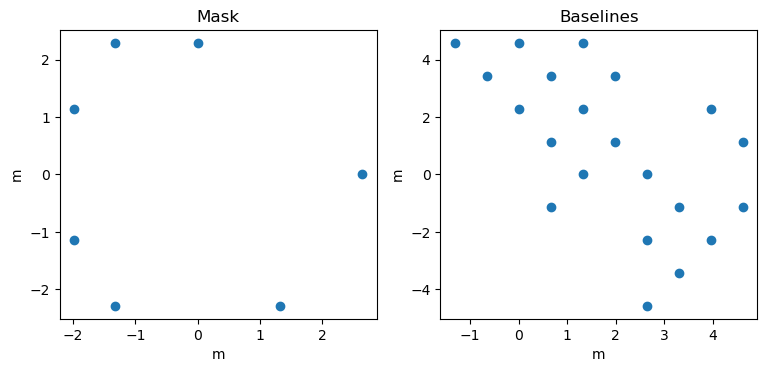

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9.0,2.5*1.5))

ax1.scatter(mask[:,0],mask[:,1])
ax1.set_xlabel('m')
ax1.set_ylabel('m')
ax1.set_title('Mask')

ax2.scatter(bls[:,0],bls[:,1])
ax2.set_xlabel('m')
ax2.set_ylabel('m')
ax2.set_title('Baselines')


In [6]:
mas2rad = np.pi / 180.0 / 3600.0/ 1000.0

def make_ellipse(semi_axis,ecc,thick,sz=80,pscale=66.):
    
    semi_axis, thick = semi_axis/pscale, thick/pscale
    
    b = semi_axis*onp.sqrt(1-ecc**2.)
    
    bmin = (semi_axis-thick)*onp.sqrt(1-ecc**2)
    
    x = onp.arange(sz)-sz/2.
    
    xx, yy = onp.meshgrid(x,x)
    
    outer = (onp.sqrt((xx/semi_axis)**2 + (yy/b)**2)< 1)
    
    inner = (onp.sqrt((xx/(semi_axis-thick))**2 + (yy/bmin)**2) >1)
       
    plain = onp.ones((sz,sz))
    
    plain[~(outer*inner)] = 0
    
    return plain/plain.sum()

def rebin(array_in,factor):
    shape = array_in.shape
    reshaped = array_in.reshape(shape[0]//factor,factor, shape[1]//factor, factor)
    return reshaped.mean(-1).mean(1)

def j1(x):
    return jax.scipy.special.bessel_jn(x,v=1,n_iter=50)[1]

def j0(x):
    return jax.scipy.special.bessel_jn(x,v=0,n_iter=50)[0]

@jit
@vmap
def jinc(x):
    dummy = 2*(j1(x)/x)
    return jax.lax.select(~np.isfinite(dummy), 1., dummy)

def vis_gauss(d,u,v):
    d = mas2rad*d
    return np.exp(-(np.pi*d*np.sqrt(u**2+v**2))**2/4./np.log(2))

def vis_ud(d,u,v):
    r = np.sqrt(u**2+v**2)
    diam = d*mas2rad
    t = jinc(np.pi*diam*r)
    return t

def vis_ring(d,u,v):
    r = np.sqrt(u**2+v**2)
    diam = d*mas2rad
    t = j0(np.pi*diam*r)
    return t
    
def vis_ellipse_disk(semi_axis,ecc,theta,u,v):
    
    semi_axis = semi_axis
    thetad = np.pi*theta/180.
    u1, v1 = u*np.cos(thetad)+v*np.sin(thetad), -u*np.sin(thetad)+v*np.cos(thetad)
    u1, v1 = u1, v1*np.sqrt(1-ecc**2.)
    
    return vis_ud(0.5*semi_axis,u1,v1)

def vis_ellipse_thin(semi_axis,ecc,theta,thick,u,v):
    
    ad, bd = semi_axis, semi_axis*np.sqrt(1.-ecc**2.)
    a2, b2 = semi_axis-thick, (semi_axis-thick)*np.sqrt(1.-ecc**2)
    n1, n2 = ad*bd, a2*b2
    return vis_ellipse_disk(semi_axis,ecc,theta,u,v)-n2/n1*vis_ellipse_disk(semi_axis-thick,ecc,theta,u,v)

def vis_ellipse_gauss(semi_axis,thick,gausswidth,ecc,theta,u,v):
    return vis_gauss(gausswidth,u,v)*vis_ellipse_thin(semi_axis,thick,ecc,theta,u,v)

def vis_ellipse_high_contrast(semi_axis,ecc,theta,thick,con,u,v):
    l2 = 1. / (con + 1)
    l1 = 1 - l2
    
    vises = vis_ellipse_thin(semi_axis,ecc,theta,thick,u,v)
    norm = vis_ellipse_thin(semi_axis,ecc,theta,thick,np.array([1e-5]),np.array([1e-5]))
    vises = l2*(vises/norm) + l1
    return vises

def vis_ring_high_contrast(diam,con,u,v):
    l2 = 1. / (con + 1)
    l1 = 1 - l2
    
    vises = vis_ring(diam,u,v)
    vises = l2*(vises) + l1
    return vises

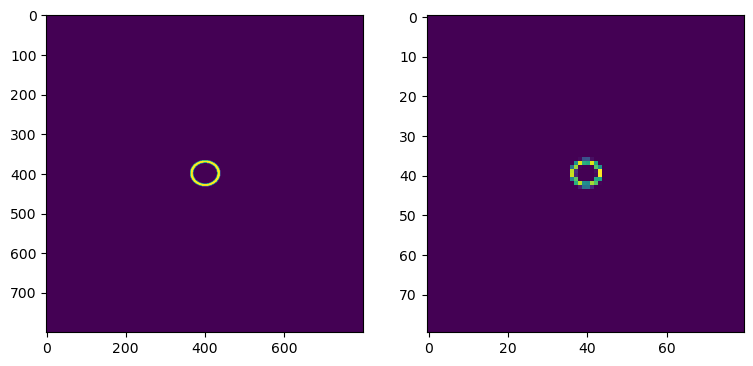

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,5))

ellipse = make_ellipse(250,0.5,50,sz=800,pscale=66/10)
ax1.imshow(ellipse)

ax2.imshow(rebin(ellipse,10))

Ok, let's make some visibility curves!

In [8]:
wavel = 4.3e-6

u, v = bls[:,0], bls[:,1]
u, v = u/wavel, v/wavel
utest = np.linspace(0.1,6.,100)/wavel

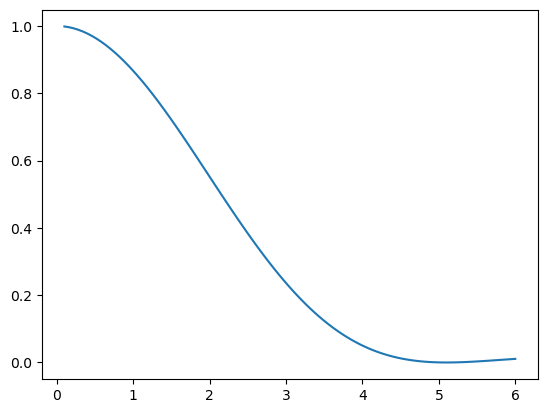

In [9]:
diam = 150.
vis = vis_ud(diam,utest,utest)**2
plt.plot(utest*wavel,vis)


In [10]:
# diam = 100.
# vis = vis_ud(diam,utest,utest)**2

# vis_thin = vis_ellipse_thin(diam*2,0,0,1,utest,utest)
# vis_thin /= vis_ellipse_thin(diam*2,0,0,1,np.array([1e-5]),np.array([1e-5]))
# vis_thin = vis_thin**2

# vis_test = vis_annular(diam,0.009,utest,utest)**2

# vis_verythin = vis_ring(diam,utest,utest)**2

# plt.plot(utest*wavel,vis,label='Filled Disk')
# plt.plot(utest*wavel,vis_thin,label='Thin Disk')
# # plt.plot(utest*wavel,vis_test**2,label='Thin Disk')
# plt.plot(utest*wavel,vis_verythin,label='Ring')


# plt.legend()

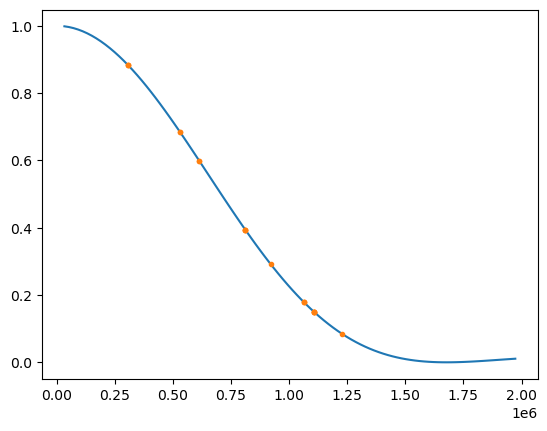

In [11]:
v2 = vis_ud(diam,u, v)**2
vis = vis_ud(diam,utest,utest)**2
plt.plot(utest*np.sqrt(2),vis)
plt.plot(np.sqrt(u**2 + v**2),v2,'.')


In [12]:
vis_ellipse_disk(80,0.5,45,u,v)

Array([0.97718274, 0.98290271, 0.96030824, 0.95429312, 0.94929282,
       0.94788399, 0.95475189, 0.99617928, 0.98715863, 0.94742714,
       0.96180581, 0.94731359, 0.95796832, 0.98477549, 0.97578517,
       0.99570724, 0.95478994, 0.97206481, 0.97485422, 0.98856712,
       0.99665142], dtype=float64)

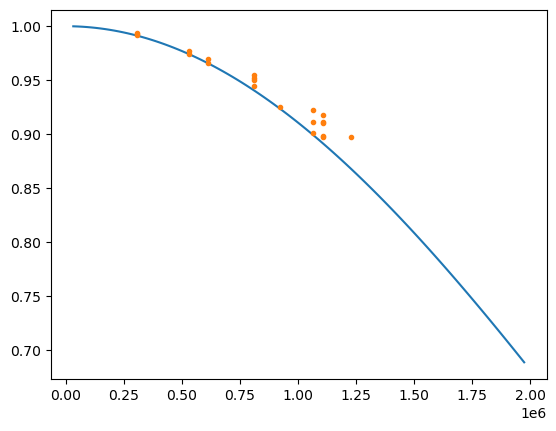

In [13]:
v2 = vis_ellipse_disk(80,0.5,45,u,v)**2
vis = vis_ellipse_disk(80,0.5,45,utest,utest)**2

plt.plot(utest*np.sqrt(2),vis)
plt.plot(np.sqrt(u**2 + v**2),v2,'.')


Now let's go to high contrast!

Text(0.5, 1.02, '1% Flux 800 mas Thin Ring')

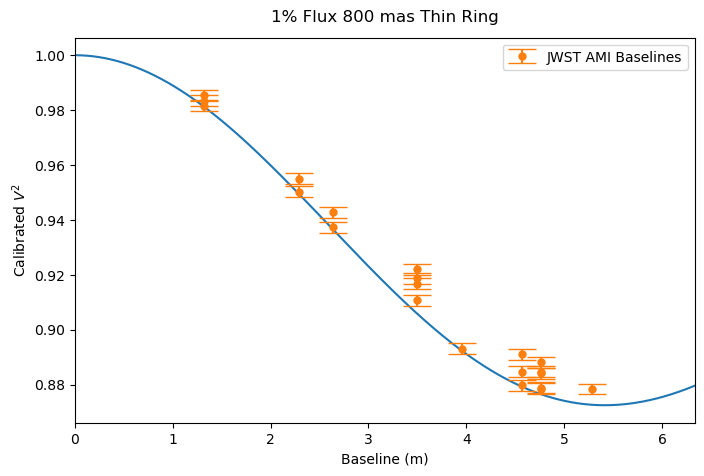

In [14]:
fig = plt.figure(figsize=(8.0,5.0))

utest = np.linspace(0,np.sqrt(u**2+v**2).max()*1.2,1000)

con = 10
width = 400e0

v2 = vis_ellipse_high_contrast(width,0.5,45.,1.,con,u,v)#**2
vis = vis_ellipse_high_contrast(width,0.5,45.,1.,con,utest,utest)#**2

plt.plot(utest*np.sqrt(2)*wavel,vis)
plt.errorbar(np.sqrt(u**2 + v**2)*wavel,v2,yerr=0.002,
             linestyle='none',fmt='.',capsize=10,markersize=10,
             label='JWST AMI Baselines')

plt.xlabel('Baseline (m)')
plt.ylabel(r'Calibrated $V^2$')
plt.xlim(utest.min()*wavel,utest.max()*wavel)

plt.legend()

plt.title('1%% Flux %.0f mas Thin Ring' % (width*2), y=1.02)

Text(0.5, 1.02, '1% Flux 400 mas Thin Ring')

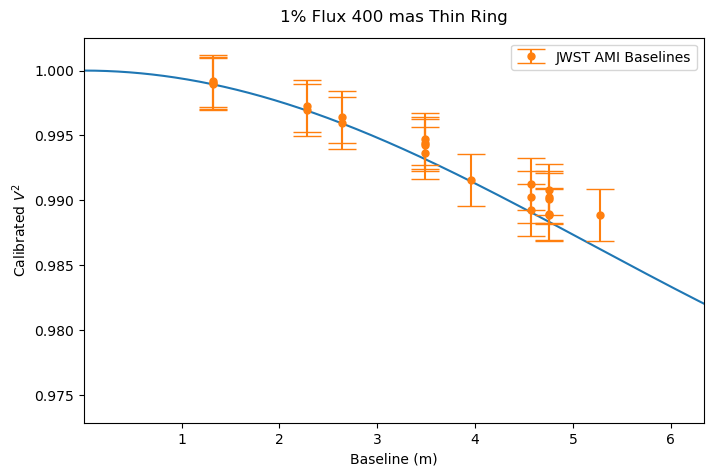

In [15]:
fig = plt.figure(figsize=(8.0,5.0))

utest = np.linspace(0.05,np.sqrt(u**2+v**2).max()*1.2,1000)

con = 100.
width = 200.

v2 = vis_ellipse_high_contrast(width,0.5,45.,1.,con,u,v)**2
vis = vis_ellipse_high_contrast(width,0.5,45.,1.,con,utest,utest)**2

plt.plot(utest*np.sqrt(2)*wavel,vis)
plt.errorbar(np.sqrt(u**2 + v**2)*wavel,v2,yerr=0.002,
             linestyle='none',fmt='.',capsize=10,markersize=10,
             label='JWST AMI Baselines')

plt.xlabel('Baseline (m)')
plt.ylabel(r'Calibrated $V^2$')
plt.xlim(utest.min()*wavel,utest.max()*wavel)

plt.legend()

plt.title('1%% Flux %.0f mas Thin Ring' % (width*2), y=1.02)

Christ, this isn't promising! We need to look at much bigger structures to make this competitive.

Text(0.5, 1.02, '20.0% Flux 44 mas Thin Ring')

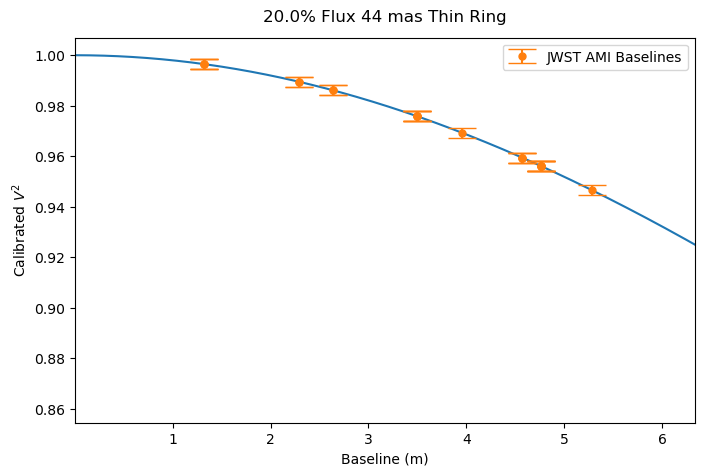

In [16]:
fig = plt.figure(figsize=(8.0,5.0))

utest = np.linspace(0.05,np.sqrt(u**2+v**2).max()*1.2,1000)

con = 5
width = 11.*4

v2 = vis_ring_high_contrast(width,con,u,v)**2
vis = vis_ring_high_contrast(width,con,utest,utest)**2

plt.plot(utest*np.sqrt(2)*wavel,vis)
plt.errorbar(np.sqrt(u**2 + v**2)*wavel,v2,yerr=0.002,
             linestyle='none',fmt='.',capsize=10,markersize=10,
             label='JWST AMI Baselines')

plt.xlabel('Baseline (m)')
plt.ylabel(r'Calibrated $V^2$')
plt.xlim(utest.min()*wavel,utest.max()*wavel)

plt.legend()

plt.title('%.1f%% Flux %.0f mas Thin Ring' % (1./con*100,width), y=1.02)

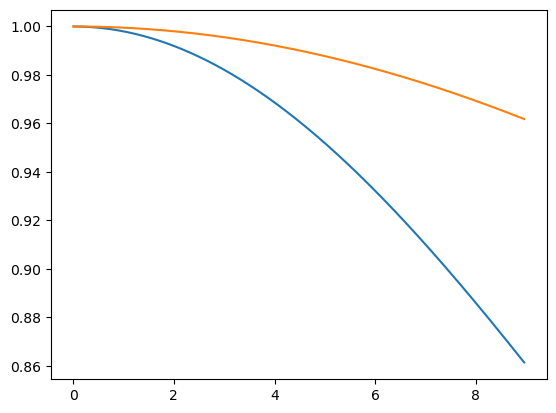

In [17]:
vis = vis_ring_high_contrast(width,con,utest,utest)**2
vis_test = vis_ellipse_high_contrast(width,0.0,0,1.,con,utest,utest)**2
plt.plot(utest*np.sqrt(2)*wavel,vis)
plt.plot(utest*np.sqrt(2)*wavel,vis_test)


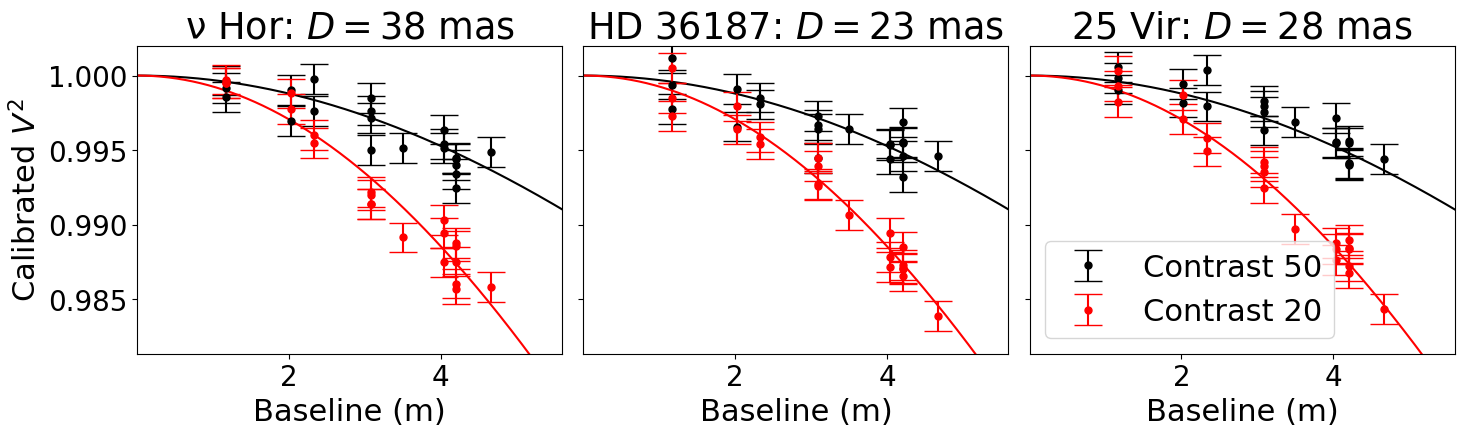

In [34]:
names = ['ν Hor', 'HD 36187', '25 Vir']
scales = [77, 46.4, 56.4]
parallaxes = [19.3,11.6,14.1]
colours = ['k','r']

con = 20.
utest = np.linspace(0.05,np.sqrt(u**2+v**2).max()*1.2,1000)
yerr = 0.001

fig, axes = plt.subplots(1,3,figsize=(17.0,4.0),sharey=True)


for j, scale in enumerate(scales):
    
    name = names[j]
    ax = axes[j]
    scale = scale/2

    
    for k, con in enumerate([50,20]):
        
        v2 = vis_ring_high_contrast(width,con,u,v)**2 + onp.random.randn(len(u))*yerr
        vis = vis_ring_high_contrast(width,con,utest,utest)**2
        
        ax.plot(utest*np.sqrt(2)*wavel,vis,color=colours[k])
        ax.errorbar(np.sqrt(u**2 + v**2)*wavel,v2,yerr=yerr,
                     linestyle='none',fmt='.',capsize=10,markersize=10,color=colours[k],
                     label='Contrast '+str(con))

    ax.set_xlabel('Baseline (m)')
    if j ==0:
        ax.set_ylabel(r'Calibrated $V^2$')
        
    ax.set_xlim(utest.min()*wavel,utest.max()*wavel)
    ax.set_ylim(v2.min()-yerr*3,1+yerr*2)
    if j == 2:
        ax.legend(loc=3)

    ax.set_title(r'%s: $D = %.0f$ mas' % (name,scale))
    
plt.subplots_adjust(wspace=0.05)

plt.savefig('disk_ensemble_yerr_001.png',bbox_inches='tight')
    


## Now let's make the observability gap

In [22]:
w = np.sqrt(u**2 + v**2)*wavel
ami_min, ami_max = w.min(), w.max()
print('AMI baselines: %.2f -> %.2f' % (ami_min, ami_max))

AMI baselines: 1.32 -> 5.28


In [23]:
hband = 1.7e-6
vlti_min = 11 # m 

In [24]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({"figure.facecolor":'w'})

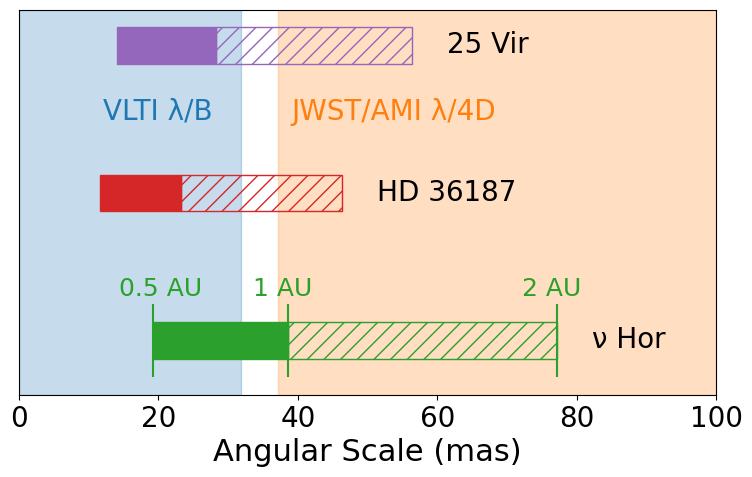

In [108]:
fig = plt.figure(figsize=(9.0,5.0))

wavel = 3.8e-6 # ami

hband = 1.7e-6 # vlti h band
vlti_min = 11 # m 

ami_ang_min, ami_ang_max = 0.25*wavel/ami_max/mas2rad, 0.5*wavel/ami_min/mas2rad

vlti_ang_max = hband/vlti_min/mas2rad

plt.axvspan(ami_ang_min,ami_ang_max,alpha=0.25,color='C1',label='JWST')
plt.axvspan(0,vlti_ang_max,alpha=0.25,color='C0',label='VLTI')

# plt.axvline(vlti_ang_max,alpha=0.5,linestyle='--',color='C0')
# plt.axvline(ami_ang_min,alpha=0.5,linestyle='--',color='C1')
plt.xlabel('Angular Scale (mas)')
plt.yticks([]);

names = ['ν Hor', 'HD 36187', '25 Vir']
scales = [77, 46.4, 56.4]
parallaxes = [19.3,11.6,14.1]

for j, parallax in enumerate(parallaxes):
    disk_min, disk_max = 0.5*parallax*2, 1*parallax*2 # 2 for *diameter*, radii from 0.5 - 4 AU 
    
#     # ruled out by VLTI
#     if vlti_ang_max > disk_min:
#         plt.barh(j,vlti_ang_max-disk_min,0.25,left=disk_min,hatch='///',color='C%d'%(j+2))
#     elif vlti_ang_max < disk_min:
#         pass

    # available parameter space
    c = 'C%d'%(j+2)
    plt.barh(j,disk_max-disk_min,0.25,left=disk_min,color=c,edgecolor=c)
    plt.barh(j,disk_max*2-disk_max,0.25,left=disk_max,color='none', edgecolor=c, hatch="//")

    plt.text(disk_max*2+5,j-0.05,names[j],fontsize=20)
    
    if j == 0:
#         yerrs = np.array([0.0,0.25])[:,np.newaxis]
        yerrs = 0.25
        plt.barh(j,disk_max-disk_min,0.25,left=disk_min,color=c,edgecolor='none',yerr=yerrs,ecolor=c)
        plt.barh(j,0,0.25,left=disk_min,color=c,edgecolor='none',yerr=yerrs,ecolor=c)

        plt.barh(j,disk_max*2-disk_max,0.25,left=disk_max,color='none', edgecolor='none', yerr=yerrs,ecolor=c)

        plt.text(disk_max/2-5,j+0.3,'0.5 AU',fontsize=18,color='C%d'%(j+2))
        plt.text(disk_max-5,j+0.3,'1 AU',fontsize=18,color='C%d'%(j+2))
        plt.text(disk_max*2-5,j+0.3,'2 AU',fontsize=18,color='C%d'%(j+2))

    
plt.xlim(0,100)

plt.text(12,1.5,'VLTI λ/B',color='C0',fontsize=20)
plt.text(ami_ang_min+2,1.5,'JWST/AMI λ/4D',color='C1',fontsize=20)

plt.savefig('parameter_space.png',bbox_inches='tight')

In [105]:
.shape

(2, 1)